<br/>
  <FONT size ="3pt"> MODAL APM_41M01 : Problem solving en math app </FONT>   
  
---
---
<FONT size ="5pt"> TP déterministe 2 : <center><b>Encodage et décodage d'image JPEG</b>  </center></FONT>

---
---
<br />

Dans ce TP, on va reconstruire les fonctions à la base de la compression d'image en JPEG. Quelques fonctions de visualisation vous sont données ainsi qu'une image (ici au format png) pour tester vos fonctions et les debugger.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import fftpack

# Représentation d'une image .png en RGB

Une façon de représenter une image est d'utiliser la base RGB (Red-Green-Blue). Dans le code ci-dessous, on extrait d'une image au format .png, les coordonnées dans la base RGB de la couleur de chacun de ses pixels. La compression jpeg va agir séparemment sur chacune des composantes R, G ou B (c'est-à-dire sur chacun des tableaux `M_R`, `M_G` ou `M_B`).

In [ ]:
def png_2_RGB(file):
    """
    Convertit l'image 'file' au format png en 3 matrices
    -------------
    paramètres :
    file : nom du fichier png à convertir

    retourne :
    M_R, M_G, M_B : les matrices contenant l'intensité (sur 255) repectivement du rouge, vert et bleu en chaque point
    """

    #plt.imread retourne l'image au bon format avec une quatrième valeur pour la transparence qu'on ne conserve pas
    M_RGB  = plt.imread(file)[:,:,:3]
    #M_RGB contient des valeurs entre 0 et 1 qui correspondent en fait à des entiers entre 0 et 255
    M_RGB *= 255
    #passage en entier (le stockage des entier allant de 1 à 255 est plus faible que celui des flottants)
    M_RGB  = M_RGB.astype(int)

    return M_RGB[:,:,0], M_RGB[:,:,1], M_RGB[:,:,2]


# on utilisera dans un premier temps l'image suivante
M_R, M_G, M_B = png_2_RGB('TP2_image.png')

On se servira régulièrement des représentations graphiques pour tester les différentes implémentations. On vous donne pour cela la fonction suivante qui prend en entrée trois matrices (typiquement les matrices RGB données précédemment) et qui trace les images correspondantes.

*Remarques :* Les matrices ne présentent qu'une intensité de couleur (rouge, vert ou bleu) et pas de teinte. On a ainsi affiché ces teintes en noir et blanc (noir=0 et blanc=255).

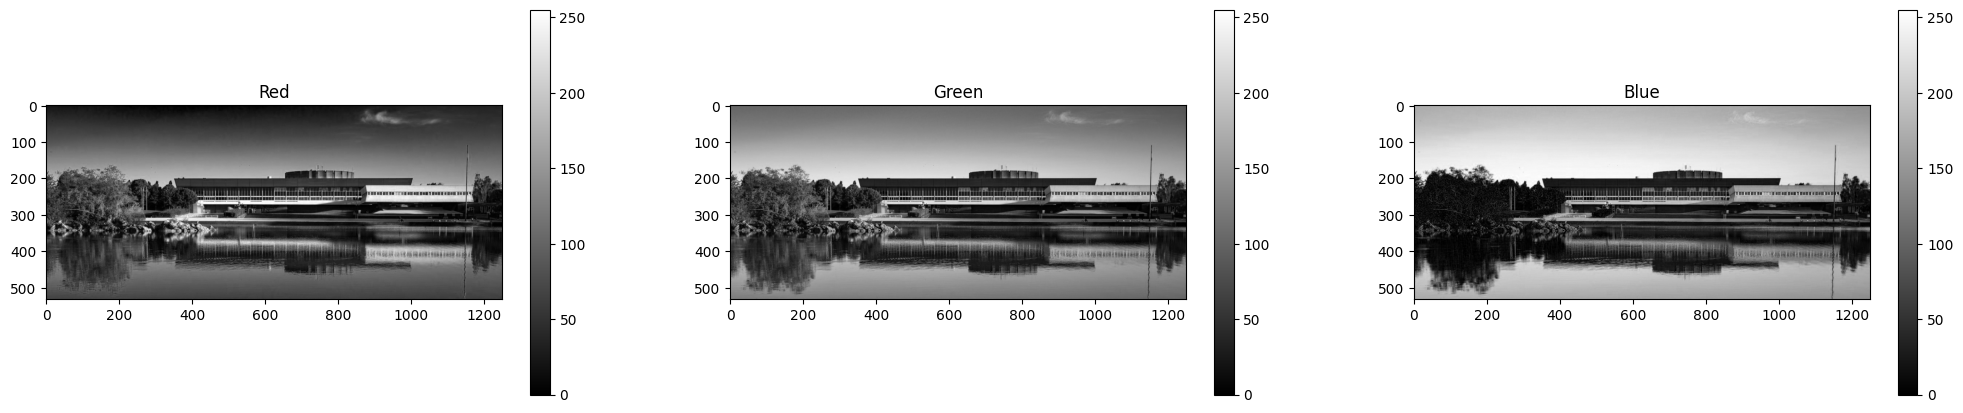

In [ ]:
def plot_3_img(M1, M2, M3, t1='',t2='',t3=''):
    """
    Trace les images 2D à partir des matrices d'intensité
    (chaque entrée M_ij correspond à l'intensité du point à la i-ème ligne et j-ème colonne)
    -------------
    paramètres :
    M1, M2, M3 : matrices d'intensité
    t1, t2, t3: (optionnel) chaines de caractères qui donnent le titre à afficher pour chaque tracé

    retourne :
    rien
    """
    plt.figure(figsize=(25, 5))

    plt.subplot(131)
    plt.imshow(M1, cmap='gray')
    plt.title(t1)
    plt.colorbar()

    plt.subplot(132)
    plt.imshow(M2, cmap='gray')
    plt.title(t2)
    plt.colorbar()

    plt.subplot(133)
    plt.imshow(M3, cmap='gray')
    plt.title(t3)
    plt.colorbar()

    plt.show()


plot_3_img(M_R, M_G, M_B,'Red','Green','Blue')

La fonction `imshow` permet d'afficher des couleurs si les trois cartes d'intensité des couleurs R, G et B lui sont données. Il faut pour cela construire un tableau de taille `Nx` $\times$ `Ny` $\times$3 contenant les trois cartes dans l'ordre R, G, B.

- Ecrire une fonction qui assemble trois matrices R, G, B (de même taille) en un seul tableau de taille `Nx` $\times$ `Ny` $\times$3.
- Tester votre fonction avec les cartes RGB calculées précédemment pour réassembler l'image.
- Visualiser l'image complète obtenue avec `imshow`.

In [ ]:
def full_img(MR, MG, MB):
    """
    construit la matrice Nx x Ny x 3
    -------------
    paramètres :
    MR, MG, MB : matrices d'intensité (de taille Nx x Ny)
    t1, t2, t3 (optionnels) : chaines de caractères qui donnent le titre à afficher pour chaque tracé

    retourne :
    M  : matrice tridimensionnelle contenant MR, MG, MB
    """

    M_RGB = np.stack((MR, MG, MB), axis=2) # On concatene les matrices en 3 dimensions suivant la dimension des couleurs (3ème dimension)
    return M_RGB

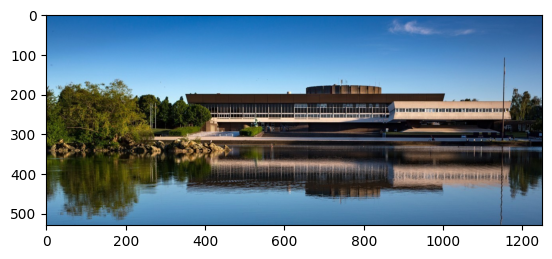

In [ ]:
# Visualisation de l'image reconstruite
plt.imshow(full_img(M_R, M_G, M_B))

# Découpage en bloc

Chaque carte de couleur est ensuite découpée en blocs de $8\times 8$ pixels. Le travail de compression s'effectuera sur chacun de ces blocs.
* Ecrire une fonction `block_decompose` qui prend en entrée un tableau 2d d'entiers et retourne un tableau 4d qui correspond au découpage en blocs de taille $8\times 8$.
* Ecrire une fonction `block_recompose` qui prend en entrée un tableau 4d de blocs de $8\times 8$ pixels et retourne un tableau 2d de pixels.
* Procéder au découpage par blocs de chacune des cartes RGB de votre image avec la fonction block_decompose. Puis, utiliser la fonction block_recompose pour reconstruire l'image complète et l'afficher. Vous devriez voir l'image intiale à laquelle il manquera éventuellement quelques lignes et colonnes de pixels (si les dimensions de l'image ne sont pas un multiple de 8 pixels).

In [ ]:
def block_decompose(M):
    """
    Décompose un tableau de pixels en blocs de 8x8 pixels
    ----------
    Paramètres :
    M : tableau 2d d'entiers

    Retourne :
    M_block : conversion de M en un tableau 4d de blocs de 8x8 pixels
    """
    Nx,Ny = M.shape

    Nx8 = int(np.floor(Nx/8))
    Ny8 = int(np.floor(Ny/8))

    M_block = np.zeros((Nx8,Ny8,8,8)).astype(int)

    for i in range(Nx8):
        for j in range(Ny8):
            M_block[i,j,:,:] = M[i*8:(i+1)*8,j*8:(j+1)*8]

    return M_block

def block_recompose(M_block):
    """
    Reconstruit un tableau 2d à partir de sa représentation par blocs de taille 8x8
    ----------
    Paramètres :
    M_block : tableau 4d de blocs de 8x8 pixels

    Retourne :
    M : tableau 2d d'entiers
    """

    Nx_8, Ny_8 = M_block.shape[:2]

    M = np.zeros((Nx_8*8,Ny_8*8)).astype(int)

    for i in range(Nx_8):
        for j in range(Ny_8):
            M[i*8:(i+1)*8, j*8:(j+1)*8] = M_block[i,j,:,:]

    return M

Dimensions de l'image originale
(530, 1250)
(530, 1250)
(530, 1250)
Dimensions des blocs
(66, 156, 8, 8)
(66, 156, 8, 8)
(66, 156, 8, 8)
Dimensions de l'image reconstruite
(528, 1248)
(528, 1248)
(528, 1248)


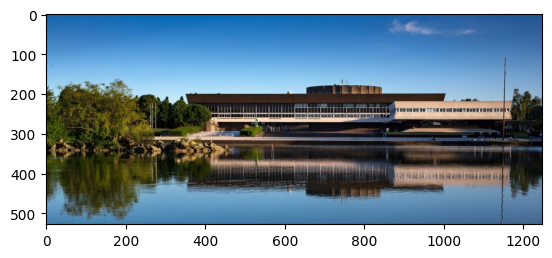

In [ ]:
print("Dimensions de l'image originale")
print(M_R.shape)
print(M_G.shape)
print(M_B.shape)

M_R_block = block_decompose(M_R)
M_G_block = block_decompose(M_G)
M_B_block = block_decompose(M_B)

print("Dimensions des blocs")
print(M_R_block.shape)
print(M_G_block.shape)
print(M_B_block.shape)

M_R_ = block_recompose(M_R_block)
M_G_ = block_recompose(M_G_block)
M_B_ = block_recompose(M_B_block)

print("Dimensions de l'image reconstruite")
print(M_R_.shape)
print(M_G_.shape)
print(M_B_.shape)

plt.imshow(full_img(M_R_, M_G_, M_B_))

# DCT : passage dans le domaine fréquentiel (sur un bloc)

La prochaine étape est d'appliquer la transformée en Cosinus Discrète à chacun des blocs de $8 \times 8$ pixels. Pour s'entrainer on travaillera d'abord sur un seul bloc $8 \times 8$ appelé B.
* Appliquer la DCT à B en utilisant la fonction `fftpack.dctn(B, norm = "ortho")` de scipy
* Visualiser B ainsi que sa transformée par la DCT. Ou se trouvent les coefficients de plus forte magnitude ? Vous pouvez tester sur différents blocs (voire différentes images) pour observer que ce comportement est en fait commun.
* Appliquer la DCT inverse `fftpack.idctn` (avec les bons arguments) et vérifiez que vous retrouvez bien votre bloc B (aux arrondis près).


*** Visualisation des matrices B, F et la DCT inverse de F ***

B=[[255 255 249 246 250 246 243 249]
 [247 253 249 253 241 241 238 254]
 [253 253 240 238 235 241 228 198]
 [250 238 209 188 187 199 218 127]
 [217 234 123  65  79  65 111  81]
 [123  96  72  42  35  43  22  37]
 [127  95  30  26  20  10  16  26]
 [ 45  34  18   7  20  29  24  40]]
F=[[ 1.18537500e+03  1.51500925e+02  8.47271438e+01  4.19649962e+01
  -2.01250000e+01 -8.76646673e+00 -2.11593325e+01 -3.46744874e-01]
 [ 7.08094007e+02 -4.94981458e+01 -5.93666154e+01 -1.43162842e+01
  -9.84660571e+00  1.10200941e+01 -5.12450390e-01  2.03903928e-01]
 [-6.42545466e+01 -9.40083903e+01 -2.88763393e+01 -2.85156819e+01
   4.19348736e+01 -9.99833589e+00  2.86438447e+01 -1.06995389e+01]
 [-1.03492026e+02  4.92471795e+01  4.49394467e+01 -1.08967801e+01
   1.05169808e+01 -1.72029903e+01 -4.63737426e-01  4.14642248e-01]
 [ 1.48750000e+01  3.45311694e-01  1.74175872e+01  1.11128721e+01
  -2.71250000e+01 -9.50935263e-02 -2.03386063e+01  1

Text(0.5, 1.0, 'F')

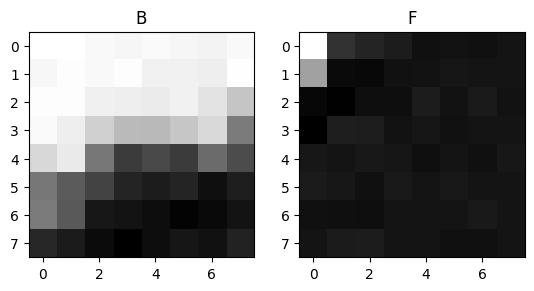

In [ ]:
B = M_B_block[25,30,:]
F = fftpack.dctn(B, norm = "ortho") # Orthonormalized type II 2-dimensional dct

print("\n*** Visualisation des matrices B, F et la DCT inverse de F ***\n")
print(f'B={B}')
print(f'F={F}')
print(f'IDCT(F)={fftpack.idctn(F, norm = "ortho")}')

print("\n*** Visualisation graphique de B, F et la DCT inverse de F ***\n")
_, (ax0, ax1) = plt.subplots(1, 2)

ax0.imshow(B, cmap='gray')
ax0.set_title('B')

ax1.imshow(F, cmap='gray')
ax1.set_title('F')


# Quantification (sur un bloc)

On continue à travailler sur un seul bloc de taille $8 \times 8$. L'étape de compression a lieu dans le domaine fréquentiel, c'est-à-dire sur le bloc $B$ après DCT, qu'on peut noter $F$. Chaque coefficient de $F$ est quantifié pour donner $G$:

$$
G_{ij} = \frac{F_{ij}}{Q_{ij}} \text{ arrondi à l'entier le plus proche}
$$

où la matrice de quantification $Q$ est donnée ci-dessous.


In [ ]:
Q = np.array([[16,11,10,16,24,40,51,61],[12,12,14,19,26,58,60,55],[14,13,16,24,40,57,69,56],[14,17,22,29,51,87,80,62],[18,22,37,56,68,109,103,77],[24,35,55,64,81,104,113,92],[49,64,78,87,103,121,120,101],[72,92,95,98,112,100,103,99]])
print(f'Q={Q}')

Q=[[ 16  11  10  16  24  40  51  61]
 [ 12  12  14  19  26  58  60  55]
 [ 14  13  16  24  40  57  69  56]
 [ 14  17  22  29  51  87  80  62]
 [ 18  22  37  56  68 109 103  77]
 [ 24  35  55  64  81 104 113  92]
 [ 49  64  78  87 103 121 120 101]
 [ 72  92  95  98 112 100 103  99]]


* Ecrire une fonction qui effectue la quantification d'un bloc F.
* L'appliquer au bloc F=dct(B) sur lequel vous avez déja travaillé. Vous devriez voir beaucoup de coefficients nuls.
* Afin de contrôler ce que vous avez fait, effectuer le décodage du bloc en multipliant par Q et en appliquant la DCT inverse. Comparer le résultat avec B.

In [ ]:
def quantification(F, Q):
    """
    Divise chaque composante F_{ij} par Q_{ij} et arrondit à l'entier le plus proche
    ----------
    Paramètres :
    F : tableau 2d de réels
    Q : tableau 2d de réels de la même taille que F (matrice de quantification)
    Retourne :
    G : tableau 2d d'entiers correspondant à la matrice F quantifiée par Q
    """

    return np.round(F / Q).astype(int)

In [ ]:
# Visualisation

G = quantification(F, Q)
print(f'G={G}')

G=[[74 14  8  3 -1  0  0  0]
 [59 -4 -4 -1  0  0  0  0]
 [-5 -7 -2 -1  1  0  0  0]
 [-7  3  2  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]


B=[[255 255 249 246 250 246 243 249]
 [247 253 249 253 241 241 238 254]
 [253 253 240 238 235 241 228 198]
 [250 238 209 188 187 199 218 127]
 [217 234 123  65  79  65 111  81]
 [123  96  72  42  35  43  22  37]
 [127  95  30  26  20  10  16  26]
 [ 45  34  18   7  20  29  24  40]]
B_=[[258 251 249 252 249 240 242 251]
 [249 248 246 246 246 244 238 233]
 [254 255 245 232 234 242 230 207]
 [250 243 212 178 177 195 183 152]
 [211 190 139  89  83 104 100  73]
 [155 125  72  27  21  37  39  25]
 [ 99  71  35  14  14  21  23  21]
 [ 55  33  16  18  23  23  24  28]]


Text(0.5, 1.0, 'B_')

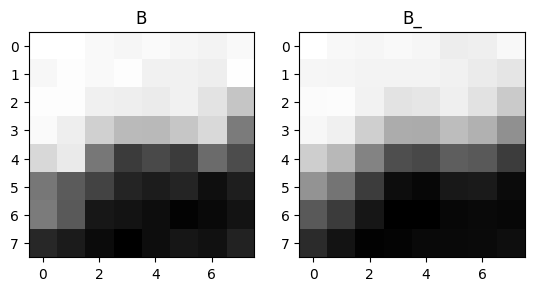

In [ ]:
# Contrôle

B_ = fftpack.idctn(G * Q, norm = "ortho").astype(int)
print(f"B={B}")
print(f'B_={B_}')

_, (ax0, ax1) = plt.subplots(1, 2)

ax0.imshow(B, cmap='gray')
ax0.set_title('B')

ax1.imshow(B_, cmap='gray')
ax1.set_title('B_')

# Encodage

Au format jpeg, les grandeurs qui sont stockées sont les grandeurs quantifiées (G). Comme on a pu le voir sur l'exemple, il y a beaucoup de coefficients nuls et les coefficients non nuls se trouvent en haut et à gauche du tableau. Cela a du sens car il s'agit des coefficients correspondant aux fréquences les plus basses.

Pour stocker les valeurs quantifiées, le tableau est parcouru en zig-zag comme illustré ci-dessous

<img src="TP4_zigzag.png" style="width:200px;"/>

A partir d'un certain rang le vecteur obtenu est nul et seules les valeurs qui se trouvent avant ce rang sont stockées selon une méthode de codage entropique appelé codage de Huffman.
* On vous donne la fonction G_zigzag qui parcourt le bloc pour former le vecteur de ses valeurs dans le bon ordre. L'appliquer à votre bloc quantifié pour vérifier qu'elle est correcte.
* Ecrire une fonction taux_compression qui estime le taux de compression d'un bloc par la valeur $i$/64 où $i$ est le rang à partir duquel toutes les entrées du vecteur sont nulles. Cette fonction fera appel à la fonction G_zigzag.


In [ ]:
def zigzag(G):
    """
    Transforme une matrice en un vecteur en suivant l'ordre donné par le zig-zag
    -------------
    paramètre :
    G   : matrice carrée

    retourne :
    vec : vecteur de taille len(G)*len(G) qui contient les composantes de G dans l'ordre donné par le zig-zag
    """
    return np.concatenate([np.diagonal(G[::-1,:], k)[::(2*(k % 2)-1)] for k in range(1-G.shape[0], G.shape[0])])

In [ ]:
# Tester zigzag
G_zigzag = zigzag(G)

print(f'G={G}')
print(f'G_zigzag={G_zigzag}')
print(G.shape)

G=[[74 14  8  3 -1  0  0  0]
 [59 -4 -4 -1  0  0  0  0]
 [-5 -7 -2 -1  1  0  0  0]
 [-7  3  2  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]
G_zigzag=[74 14 59 -5 -4  8  3 -4 -7 -7  1  3 -2 -1 -1  0  0 -1  2  0  1  0  0  0
  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(8, 8)


In [ ]:
def last_non_null_index(T):
    """
    Retourne l'indice à partir duquel on n'a que des zeros dans T
    -------------
    paramètre :
    T   : vecteur

    retourne :
    k : indice à partir duquel on n'a que des zeros dans T
    """
    n = T.shape[0]
    k_ = np.argmax(T[::-1] != 0) # Retourne la position de la 1ère valeur non nulle de T inversée
    return n - k_ # Indice à partir duquel on n'a que des zeros dans T

def taux_compression(G):
    """
    Calcule le taux de compression
    -------------
    paramètre :
    G_vec  : vecteur

    retourne :
    taux : estimation du taux de compression
    """

    G_zigzag = zigzag(G)

    k = last_non_null_index(G_zigzag)

    return k / len(G_zigzag)

In [ ]:
# Tester taux_compression

print(f'taux_compression(G)={taux_compression(G)}')

taux_compression(G)=0.40625


# Mise en oeuvre sur l'image complète

* Ecrire une fonction `compress` qui effectue la DCT et la quantification sur chacun des blocs d'une des cartes RGB de votre image. On retournera aussi l'estimation du taux de compression pour chacune des cartes. (Pour que l'image soit réellement compressée il faudrait procéder à l'encodage de l'image quantifiée mais cela dépasse le cadre de ce TP).
* Ecrire une fonction `decompress` qui décode l'image à partir de l'image quantifiée.
* Appliquer tout le processus de compression/décompression à votre image et comparer à l'image initial.
* Vous pouvez tester votre algorithme avec différentes images.

In [ ]:
def compress(MR, Q):
    """
    Compresse une des carte RGB d'une image
    -------------
    paramètre :
    MR   : matrice: carte R, G ou B
    Q    : matrice de quantification (donnée plus haut)

    retourne :
    G    : matrice compressée (après DCT et quantification sur chacun des blocs)
    taux : taux de compression estimé
    """

    MR_block = block_decompose(MR)
    Nx, Ny = MR_block.shape[:2]
    rate = 0

    for i in range(Nx):
        for j in range(Ny):
            MR_block[i,j,:,:] = quantification(fftpack.dctn(MR_block[i,j,:,:], norm = "ortho"), Q)
            rate += taux_compression(MR_block[i,j,:,:])

    return MR_block, rate / (Nx*Ny)

def decompress(GR,Q):
    """
    Déccompresse une matrice de fréquence en carte RGB d'une image
    -------------
    paramètre :
    GR   : matrice des fréquences
    Q    : matrice de quantification (donnée plus haut)

    retourne :
    MR   : carte RGB (apres multiplication par Q de chacun des blocs et DCT inverse)
    """

    Nx, Ny = GR.shape[:2]
    GR_decomp = np.empty_like(GR)
    for i in range(Nx):
        for j in range(Ny):
            GR_decomp[i,j,:,:] = fftpack.idctn(GR[i,j,:,:] * Q, norm = "ortho")

    return np.clip(block_recompose(GR_decomp), 0, 255) # On se ramène à la plage [0, 255]

In [ ]:
# Cette cellule vous est donnée pour débugger

# Qones = np.ones([8,8]) #peut être utile pour débugger

G_R, tauxR =   compress(M_R, Q)
G_G, tauxG =   compress(M_G, Q)
G_B, tauxB =   compress(M_B, Q)
R          = decompress(G_R, Q)
G          = decompress(G_G, Q)
B          = decompress(G_B, Q)

taux_moyen = 1./3*(tauxR+tauxG+tauxB)
print(f'Taux de compression moyen = {taux_moyen}')
print(f'avec {tauxR} pour R, {tauxG} pour G, {tauxB} pour B')

Image         = full_img(M_R, M_G, M_B)
Image_filtree = full_img(R  ,   G,   B)

print(Image.shape)
print(Image_filtree.shape)

plt.figure(figsize=(25, 25))
plt.imshow(Image_filtree)
plt.title('Image filtree')
plt.show()


Difference = Image[:len(Image_filtree[:,0,0]),:len(Image_filtree[0,:,0]),:]-Image_filtree
print(Image.shape, Image_filtree.shape, Difference.shape)

plot_3_img(Image, Image_filtree, Difference, 'Original', 'Filtree', 'Difference')

print()
plot_3_img(R    ,   G  ,     B, 'R filtree', 'G filtree', 'B filtree')
plot_3_img(M_R  , M_G  ,   M_B, 'R originale', 'G originale', 'B originale')
plot_3_img(R-M_R[:len(R[:,0]),:len(R[0,:])], G-M_G[:len(G[:,0]),:len(G[0,:])], B-M_B[:len(B[:,0]),:len(B[0,:])], 'R difference', 'G difference', 'B difference')

Output hidden; open in https://colab.research.google.com to view.

# Pour aller plus loin




## Format de stockage pour une compression effective

Pour l'instant, les zéros de la matrice des fréquences sont toujours stockés. Pour réduire le stockage de la matrice, on va maintenant chercher à supprimer ces zéros.

- Proposer un stockage efficace pour minimiser la quantité d'information à stocker. On pourra revenir à la fonction `G_zigzag` donnée dans la partie Encodage.
- Implémenter une fonction transformant le stockage plein en ce format.
- Comparer la tailler des vecteurs stockées avec chacun des deux stockage. Comparer également avec le taux de compression que vous avez calculé.
- Implémenter une fonction qui permet de tracer une image à partir de votre stockage réduit.

In [ ]:
def encode(MR_block):
    """
    Transforme une matrice (R, G ou B) en un vecteur en suivant l'ordre donné par le zig-zag
    -------------
    paramètre :
    MR_block   : matrice carrée

    retourne :
    MR_encode  : vecteur de taille le nombre total d'éléments non nuls après l'application de zig-zag à tous les blocs
    """

    nx, ny = MR_block.shape[:2]
    n_blocks = nx * ny
    MR_encode = np.zeros(n_blocks * 64, dtype=int) # Matrice d'encodage des valeurs non nulles après le zigzag, initialisée avec unt taille suffisante pour un début
    # offsets permettra de trouver la position de chaque bloc dans MR_encode
    offsets = np.zeros(n_blocks+1, dtype=int) # Le dernier élément permettra de stocker nx
    offsets[-1] = nx

    l = 0 # indice de l'évolution dans MR_encode
    for i in range(nx):
        for j in range(ny):
            block_zigzag = zigzag(MR_block[i, j])

            # On trouve l'indice du dernier élt non null + 1
            k = last_non_null_index(block_zigzag)

            # On ne stocke que les valeurs non nulles
            MR_encode[l:l+k] = block_zigzag[:k]
            offsets[i*ny + j] = l
            l += k

    # On retire les éventuels 0 en fin de MR_encode
    k = last_non_null_index(MR_encode) # On trouve l'indice du dernier élt non null + 1
    return MR_encode[:k], offsets

R_encode, R_offsets = encode(G_R)
G_encode, G_offsets = encode(G_G)
B_encode, B_offsets = encode(G_B)

print("len(G_R) =", G_R.size)
print("R_encode:\n", R_encode)
print("\tlen =", len(R_encode))
print("R_offsets\n", R_offsets)
print("\tlen =", len(R_offsets))

print("\nlen(G_G) =", G_G.size)
print("G_encode:\n", G_encode)
print("\tlen =", len(G_encode))
print("G_offsets\n", G_offsets)
print("\tlen =", len(G_offsets))

print("\nlen(G_B) =", G_B.size)
print("B_encode:\n", B_encode)
print("\tlen =", len(B_encode))
print("B_offsets\n", B_offsets)
print("\tlen =", len(B_offsets))

n_init = G_R.size + G_G.size + G_B.size
n_final = R_encode.size + R_offsets.size + G_encode.size + G_offsets.size + B_encode.size + B_offsets.size

print(f"\n- Avant l'encodage, on conservait tous les éléments soit {n_init} éléments.")
print(f"- Avec l'encodage on stocke maintenant {n_final} éléments.")
print(f"\t soit un ratio de stockage de : {n_final / n_init}")
print(f"\nOr en amont on avait eu un taux de compression de {taux_moyen}.")
print(f"L'approche par le stockage linéaire + offsets implementée est ainsi efficace en matière de stockage,\n\tvu que le rapport de stockage est juste légèrement au dessus du taux de compression")

len(G_R) = 658944
R_encode:
 [11  0 -1 ... 33  0  2]
	len = 138534
R_offsets
 [     0      3      6 ... 138530 138531     66]
	len = 10297

len(G_G) = 658944
G_encode:
 [51 51  0 ... 51  0  1]
	len = 137580
G_offsets
 [     0      1      4 ... 137574 137577     66]
	len = 10297

len(G_B) = 658944
B_encode:
 [86 85  0 ... 71  0  1]
	len = 135722
B_offsets
 [     0      1      4 ... 135718 135719     66]
	len = 10297

- Avant l'encodage, on conservait tous les éléments soit 1976832 éléments.
- Avec l'encodage on stocke maintenant 442727 éléments.
	 soit un ratio de stockage de : 0.22395782747345247

Or en amont on avait eu un taux de compression de 0.2083313098938099.
L'approche par le stockage linéaire + offsets implementée est ainsi efficace en matière de stockage,
	vu que le rapport de stockage est juste légèrement au dessus du taux de compression


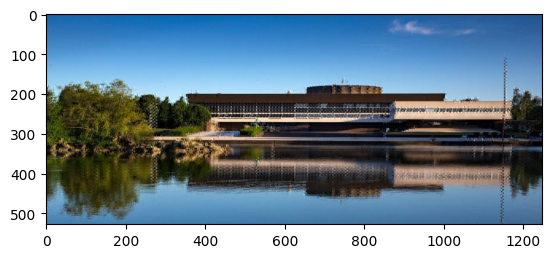

In [ ]:
# Processus de visualisation d'une image encodée

def zigzag_indices(shape):
    """
    Retourne les indices de zigzag pour une matrice de taille shape
    """
    i, j = np.indices(shape)
    s = i + j # va nous donner l'ordre initial de parcours (suivant les diagonales antisymétiques)
    w = np.where(i & 1, i, -i) # va nous donner l'ordre de parcours sur chaque diagonale antisymétrique : vers le haut si i est impair et vers le bas sinon

    # On retourne l'ordre de parcours qui est définit d'abord par s (vu comme un vecteur) et ensuite par w (vu comme un vecteur)
    return np.lexsort((w.ravel(), s.ravel()))

def unzigzag(G_zigzag):
    """
    Retourne la matrice de taille 8x8 correspondant au vecteur G_zigzag
    """

    indices = zigzag_indices((8, 8))
    G_unzigzag = np.zeros(64, dtype=int)
    G_unzigzag[indices] = G_zigzag
    return G_unzigzag.reshape(8, 8)

def decode(M_encode, M_offsets):
    """
    Décode une matrice (R, G ou B) à partir de son encodage
    -------------
    paramètre :
    M_encode   : vecteur de taille le nombre total d'éléments non nuls après l'application de zig-zag à tous les blocs
    M_offsets  : vecteur de taille nx+1

    retourne :
    M_decode    : matrice décodée
    """

    n_blocks = len(M_offsets)-1 # on retire 1 car M_offsets[-1] stocke nx
    nx = M_offsets[-1]
    ny = n_blocks // nx

    M_decode = np.zeros((nx, ny, 8, 8))

    for l in range(n_blocks):
        # les valeurs non nulles du block à la position (i,j) tel que i*ny + j = l sont dans M_encode[M_offsets[l]:M_offsets[l+1]] si l < n_blocks - 1
        if l < n_blocks - 1:
            next_offset = M_offsets[l + 1]
        else:
            # Il s'agit du dernier bloc, donc on ajoute le nombre de valeurs non nulles restantes
            next_offset = len(M_encode)

        # On recupère les valeurs non nulles du block
        Block_zigzag = M_encode[M_offsets[l]:next_offset]
        i, j = divmod(l, ny) # on retrouve sa position (i,j)
        # On rajoute les 0 rétirés lors de l'encodage
        padded_block = np.pad(Block_zigzag, (0, 64 - len(Block_zigzag)))
        # On reconstruit le block
        M_decode[i, j, :, :] = unzigzag(padded_block)

    return M_decode

def plot_encode_img(R_encode, G_encode, B_encode, R_offsets, G_offsets, B_offsets):
    """
    Trace une image à partir de son encodage
    """

    # On décode les matrices de couleurs
    G_R_reconstruit = decode(R_encode, R_offsets)
    G_G_reconstruit = decode(G_encode, G_offsets)
    G_B_reconstruit = decode(B_encode, B_offsets)

    # On les décompresse
    R_final = decompress(G_R_reconstruit, Q)
    G_final = decompress(G_G_reconstruit, Q)
    B_final = decompress(G_B_reconstruit, Q)

    # print(R_final.shape)
    # print(G_final.shape)
    # print(B_final.shape)

    plt.imshow(full_img(R_final, G_final, B_final))

plot_encode_img(R_encode, G_encode, B_encode, R_offsets, G_offsets, B_offsets)

## Standard chromatique YCbCr

Pour un meilleur rendu, d'autres cartes chromatiques sont parfois préféré au RGB. Par exemple, le standard YCbCr consiste à utiliser l'intensité lumineuse $Y = R + G + B$, la distance au bleu $Cb = B-Y$ et la distance au rouge $Cr = R-Y$.

- Implémenter une fonction qui passe une carte RGB en YCbCr et une fonction qui passe une carte YCbCr en RGB.
- Appliquer votre compression sur une carte YCbCr et comparer les résultats avec celui sur la carte RGB.
- De même avec d'autre normes utilisées, cf https://en.wikipedia.org/wiki/YCbCr.

In [ ]:
def RGB_YCbCr(R, G, B):
    """
    Transforme une carte RGB en une carte YCbCr
    -------------
    paramètres :
    R   : carte R
    G   : carte G
    B   : carte B

    retourne :
    Y   : carte Y
    Cb  : carte Cb
    Cr  : carte Cr
    """

    Y = R + G + B
    Cb = B - Y
    Cr = R - Y
    return Y, Cb, Cr

def YCbCr_RGB(Y, Cb, Cr):
    """
    Transforme une carte YCbCr en une carte RGB
    -------------
    paramètres :
    Y   : carte Y
    Cb  : carte Cb
    Cr  : carte Cr

    retourne :
    R   : carte R
    G   : carte G
    B   : carte B
    """

    B = Cb + Y
    R = Cr + Y
    G = Y - R - B
    return R, G, B

In [ ]:
# Implémntation de la compression avec le standard YCbCr

Y, Cb, Cr = RGB_YCbCr(M_R, M_G, M_B)

G_Y, tauxY =   compress(Y, Q)
G_Cb, tauxCb = compress(Cb, Q)
G_Cr, tauxCr = compress(Cr, Q)

taux_moyen_stand = 1./3*(tauxY+tauxCb+tauxCr)
print(f'Taux de compression moyen avec le standard YCbCr = {taux_moyen_stand}')
print(f'avec {tauxY} pour R, {tauxCb} pour G, {tauxCr} pour B')

print(f'Taux de compression moyen avec le standard RGB = {taux_moyen}')
print(f'avec {tauxR} pour R, {tauxG} pour G, {tauxB} pour B')

Taux de compression moyen avec le standard YCbCr = 0.32887316676379175
avec 0.4350855307886558 pour R, 0.27512656614219116 pour G, 0.2764074033605284 pour B
Taux de compression moyen avec le standard RGB = 0.2083313098938099
avec 0.2102363782051282 pour R, 0.20878860722610723 pour G, 0.20596894425019424 pour B


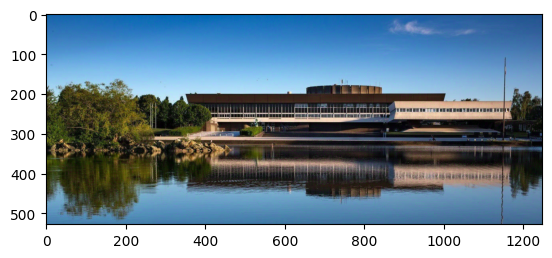

In [ ]:
# On reconstitue l'image original, question de vérifier que les implémentations sont bonnes

G_R_2, G_G_2, G_B_2 = YCbCr_RGB(G_Y, G_Cb, G_Cr)
R_2 = decompress(G_R_2, Q)
G_2 = decompress(G_G_2, Q)
B_2 = decompress(G_B_2, Q)

plt.imshow(full_img(R_2, G_2, B_2))

## Sous-échantillonage chromatique

Une première étape de compression est parfois utilisée avant la décomposition en bloc. Cette première décomposition consiste, à partir du standard chromatique YCbCr, à réduire la qualité des couleurs Cb et Cr en gardant la qualité en luminance Y intacte. Pour cela, on réduit simplement la taille de ces matrices. Là-encore, il existe plusieurs standard (cf https://fr.wikipedia.org/wiki/Sous-%C3%A9chantillonnage_de_la_chrominance). Le plus courant est le "4:2:0" qui consiste à ne garder qu'une seule valeur de Cb et de Cr sur chaque bloc de taille $4 \times 4$ (ou à supprimer une valeur sur deux).

- Implémenter une fonction qui prend en entrée la carte Cb ou Cr de taille $N_x \times N_y$ et renvoie une carte de taille $\frac{N_x}{2} \times \frac{N_y}{2}$.
- Implémenter une fonction qui renconstruit la carte de la bonne taille (malgré la perte d'information).
- Tracer une image reconstruite après avoir fait ce sous-échantillonage. Que se passe-t'il si $N_x$ ou $N_y$ est impaire?

In [ ]:
def cb_cr_sub(Cb, Cr):
    """
    Réduit la qualité des couleurs Cb et Cr en gardant la qualité en luminance Y intacte
    -------------
    paramètres :
    Cb  : carte Cb
    Cr  : carte Cr

    retourne :
    Cb_sub  : carte Cb sous-échantillonée
    Cr_sub  : carte Cr sous-échantillonée
    """

    return Cb[::2, ::2], Cr[::2, ::2]

def cb_cr_reconst(Cb_sub, Cr_sub):
    """
    Réconstruit une carte Cb ou Cr sous-échantillonée
    -------------
    paramètres :
    Cb_sub  : carte Cb sous-échantillonée
    Cr_sub  : carte Cr sous-échantillonée

    retourne :
    Cb  : carte Cb
    Cr  : carte Cr
    """

    Nx_2, Ny_2 = Cb_sub.shape
    Nx, Ny = Nx_2 * 2, Ny_2 * 2

    Cb = np.zeros((Nx, Ny), dtype=int)
    Cr = np.zeros((Nx, Ny), dtype=int)
    # Cb = np.repeat(np.repeat(Cb_sub, 2, axis=0), 2, axis=1)
    # Cr = np.repeat(np.repeat(Cr_sub, 2, axis=0), 2, axis=1)
    Cb[::2, ::2] = Cb_sub
    Cb[1::2, ::2] = Cb_sub
    Cb[::2, 1::2] = Cb_sub
    Cb[1::2, 1::2] = Cb_sub

    Cr[::2, ::2] = Cr_sub
    Cr[1::2, ::2] = Cr_sub
    Cr[::2, 1::2] = Cr_sub
    Cr[1::2, 1::2] = Cr_sub
    return Cb, Cr

In [ ]:
# On sous-échantillonne les couleurs
Cb_sub, Cr_sub = cb_cr_sub(Cb, Cr)

print(f"Cb shape = {Cb.shape}")
print(f"Cr shape = {Cr.shape}")
print(f"Cb_sub shape = {Cb_sub.shape}")
print(f"Cr_sub shape = {Cr_sub.shape}")

Cb shape = (530, 1250)
Cr shape = (530, 1250)
Cb_sub shape = (265, 625)
Cr_sub shape = (265, 625)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-595..874].


Cb shape = (530, 1250)
Cr shape = (530, 1250)


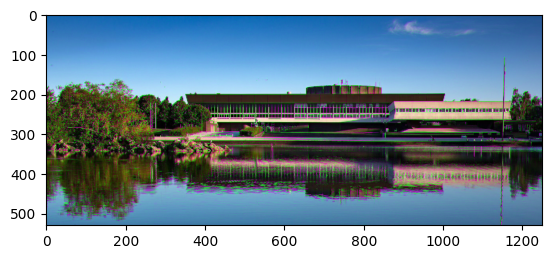

In [ ]:
# On reconstruit les couleurs
Cb_reconst, Cr_reconst = cb_cr_reconst(Cb_sub, Cr_sub)

print(f"Cb shape = {Cb.shape}")
print(f"Cr shape = {Cr.shape}")

R_reconst, G_reconst, B_reconst = YCbCr_RGB(Y, Cb_reconst, Cr_reconst)
plt.imshow(full_img(R_reconst, G_reconst, B_reconst))

### Gestion du cas où au moins une dimension est impaire

Lorsque l'on sous-échantillonne une image avec une dimension impaire (par exemple, une largeur de 5 pixels), le résultat est arrondi à la taille supérieure (3 pixels). La reconstruction par duplication crée alors une image trop grande (6 pixels).

La solution la plus directe est d'effectuer cette reconstruction, puis de rogner l'image agrandie pour qu'elle corresponde exactement aux dimensions originales.

Par exemple, une ligne de 3 pixels sous-échantillonnés [P0, P2, P4] est d'abord reconstruite en une ligne de 6 pixels [P0, P0, P2, P2, P4, P4]. On la coupe ensuite pour la ramener à la taille originale de 5 : [P0, P0, P2, P2, P4].